In [2]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

# Parameter setting

Plot formatting

In [219]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [4]:
plot_dir = '../plots/2023-03-26_figures'
save = False

Names

In [5]:
name_catalog = '\emph{{Gaia}} Cosmological Quasar Catalog'
abbrv_catalog = 'GaiaQ'

name_gpurer = '\emph{{Gaia}} Purer Sample'
abbrv_gpurer = '\emph{{Gaia}} Purer'

Plotting variables

In [99]:
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0, name='Blues_shifted')
cmap_hist = 'inferno_r'

color_gaia = 'purple'

Functions

In [7]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [8]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [9]:
G_hi = 20.5
G_lo = 20.0

In [10]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

In [11]:
fn_gall = '../data/gaia_candidates.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [12]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [13]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [14]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1442077


In [210]:
fn_gqlo = f'../data/gaiaQ_G{G_lo}.fits'
tab_gqlo = utils.load_table(fn_gqlo)
print(len(tab_gqlo))

767866


In [211]:
fn_gqhi = f'../data/gaiaQ_G{G_hi}.fits'
tab_gqhi = utils.load_table(fn_gqhi)
print(len(tab_gqhi))

1318566


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [15]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_squasars['mag_w1_vg']) & ~tab_squasars.mask['mag_w1_vg']))

Number of SDSS quasars: 379698
Number with unWISE info: 350070


In [16]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sstars['mag_w1_vg']) & ~tab_sstars.mask['mag_w1_vg']))

Number of SDSS stars: 683221
Number with unWISE info: 482080


In [17]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sgals['mag_w1_vg']) & ~tab_sgals.mask['mag_w1_vg']))

Number of SDSS galaxies: 717059
Number with unWISE info: 600897


Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [18]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 249714


# Figures

### Purer map

TODO: should i limit to having QSOC redshifts here? (now just do G lim)

TODO: healpy / matplotlib error with show_tickmarkers=True

In [ ]:
i_Ghi = tab_gpurer['phot_g_mean_mag'] < G_hi

map_gpurer = get_ndens_map(tab_gpurer['ra'][i_Ghi], tab_gpurer['dec'][i_Ghi], NSIDE=NSIDE)

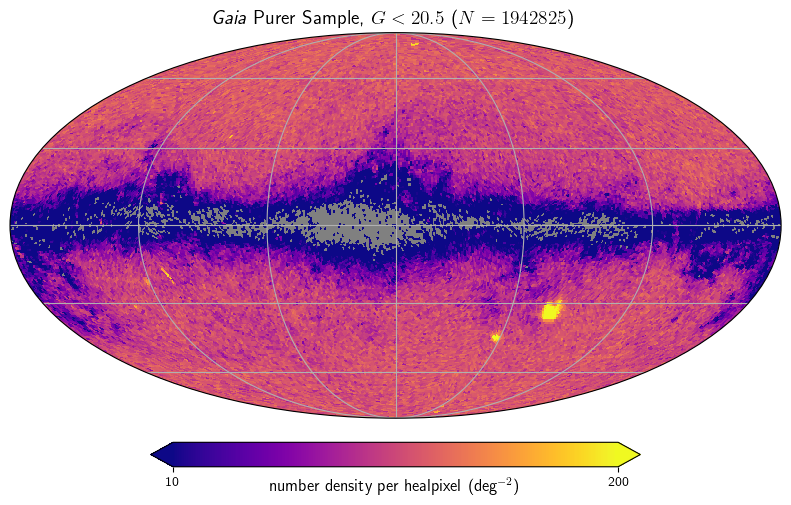

In [20]:
projview(map_gpurer, title=rf"{name_gpurer}, $G<{G_hi}$ ($N={len(tab_gpurer)}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True,
            #show_tickmarkers=True
        )

### Decontamination

In [112]:
def plot_cut(ax, cut, x_eq=None, y_eq=None, only_plot=None, only_axis=None,
             xlim=None, ylim=None):

    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    xx = np.array(xlim)
    yy = np.array(ylim)
    if only_plot=='above':
        if only_axis=='x':
            xx[0] = x_eq
        if only_axis=='y':
            yy[0] = y_eq
    if only_plot=='below':
        if only_axis=='x':
            xx[1] = x_eq
        if only_axis=='y':
            yy[1] = y_eq
            
            
    #ax.plot(xx, cut[0]*xx+cut[1], 'k-', lw=0.7)
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)

In [32]:
tag_decontam = '_mag0.1-0.01'
#tag_decontam = '_mag0.1'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
color_names, cuts = np.genfromtxt(fn_cuts, dtype=['U15', '<f8'], unpack=True)

In [71]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)

In [106]:
tabs = [tab_squasars, tab_sstars, tab_sgals]

In [107]:
colors = ['blue', 'brown', 'orange']
labels = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies']
zorders = [1,2,3]

TODO: do we like bp_g vs g_rp, or should we do vs one of the other colors we cut on?

TODO: should i somehow show which side of the line we're taking?

(-1.0, 6.0)

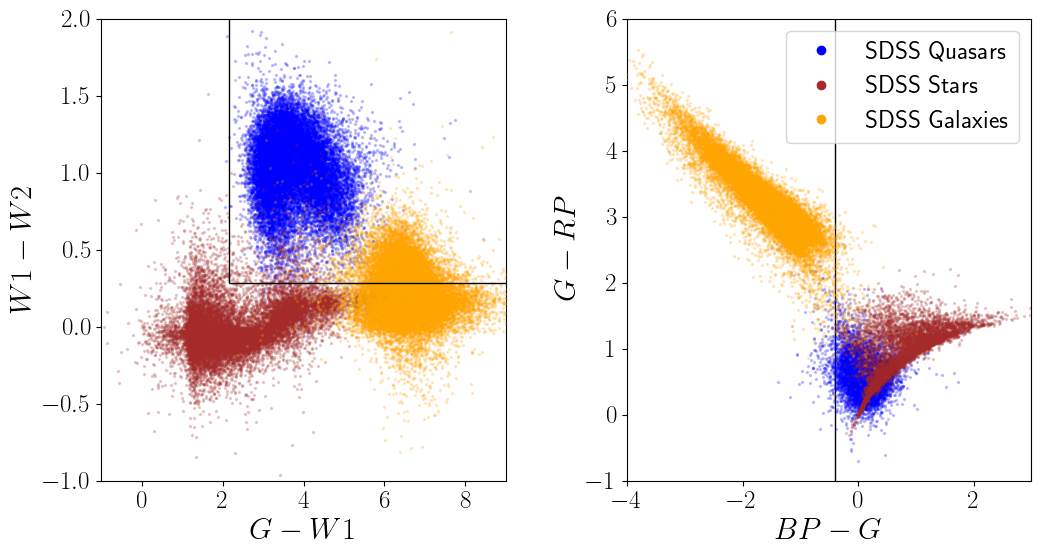

In [125]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

N_subsample = 20000
patches = []


for i in range(len(tabs)):
    tab = tabs[i]
    i_unwise = np.isfinite(tab['mag_w1_vg']) & np.isfinite(tab['mag_w2_vg'])
    i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
    tab_plot = tab[i_unwise][i_subsample]
    
        
    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax1.legend(handles=patches, loc='upper right')

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

In [127]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']

In [128]:
tabs = [tab_s, tab_g]
colors = ['brown', 'orange']
labels = ['SDSS Stars', 'SDSS Galaxies']
zorders = [1,2]

(-1.0, 6.0)

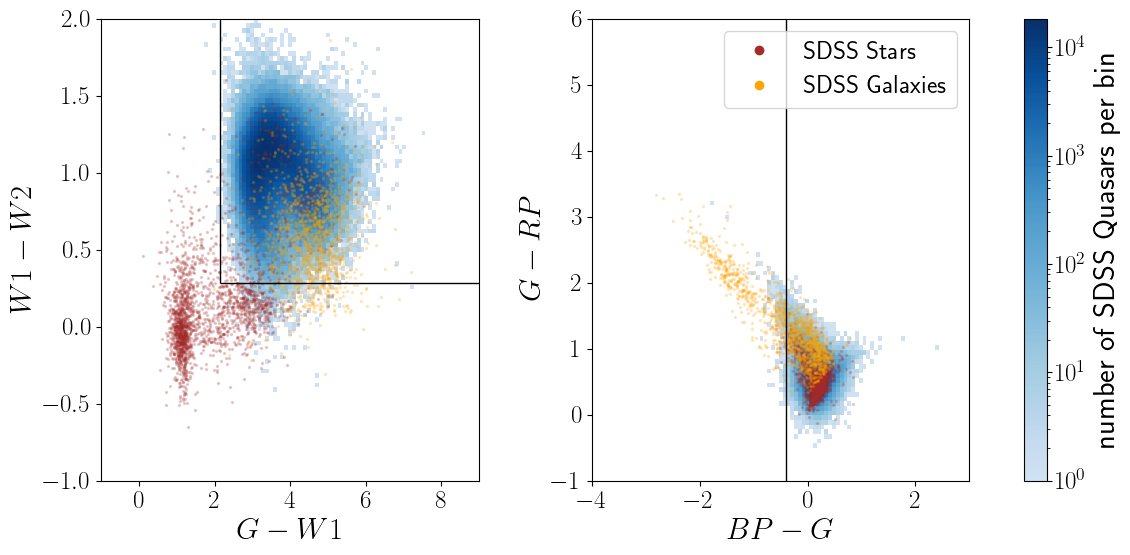

In [131]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

cmax = 5e4
g_w1 = np.array(tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'])
w1_w2 = np.array(tab_q['mag_w1_vg']-tab_q['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'])
g_rp = np.array(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label='number of SDSS Quasars per bin')

patches = []
for i in range(len(tabs)):
    tab_plot = tabs[i]

    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax1.legend(handles=patches, loc='upper right')

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

(-1.0, 6.0)

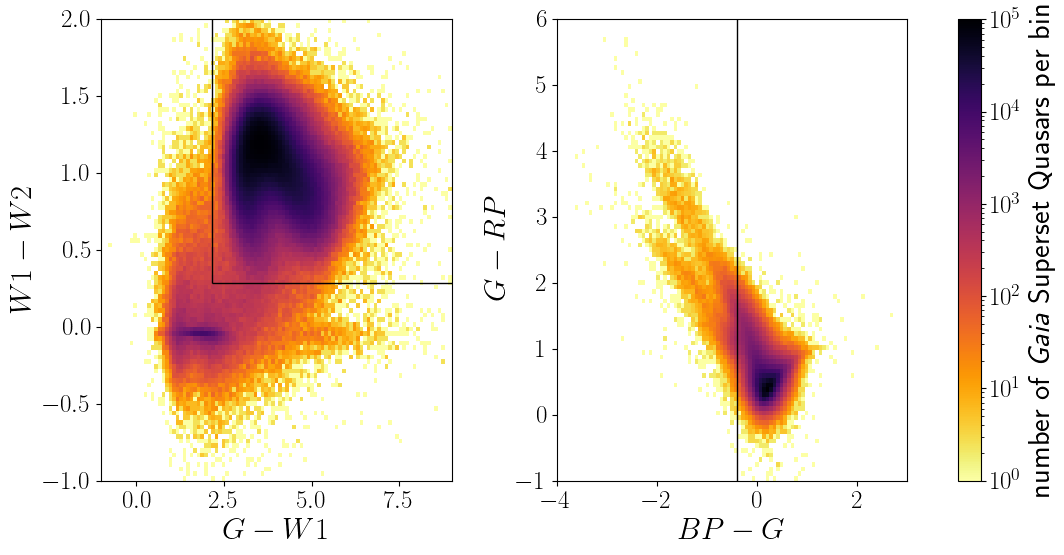

In [132]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

g_w1 = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['mag_w1_vg'])
w1_w2 = np.array(tab_gsup['mag_w1_vg']-tab_gsup['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmap=cmap_hist, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_gsup['phot_bp_mean_mag']-tab_gsup['phot_g_mean_mag'])
g_rp = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmap=cmap_hist, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label=r'number of \emph{Gaia} Superset Quasars per bin')

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

## Redshift analysis vs SDSS

In [156]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


TODO: Should i show these for all labeled and not just test? Looks much nicer when i do, but not entirely fair to include training set

In [157]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [158]:
idx_Glo_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_lo

In [159]:
idx_Ghi_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_hi

### Redshift estimates vs SDSS accuracy

In [160]:
z_sdss_test = tab_spz_labeled['z_sdss'][i_test]
z_spzraw_test = tab_spz_labeled['redshift_spz_raw'][i_test]
z_spz_test = tab_spz_labeled['redshift_spz'][i_test]
z_gaia_test = tab_spz_labeled['redshift_qsoc'][i_test]

In [161]:
z_bins = np.linspace(0, np.max(z_gaia_test), 200)

Text(0, 0.5, '$z_\\mathrm{\\textit{Gaia}}$, Gaia redshift')

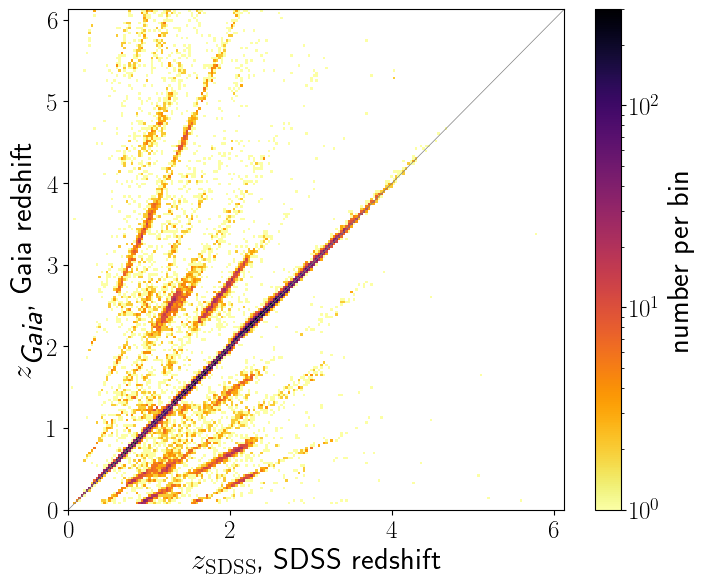

In [162]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_gaia_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

Text(0, 0.5, '$z_\\mathrm{\\textit{Gaia}}$, Gaia redshift')

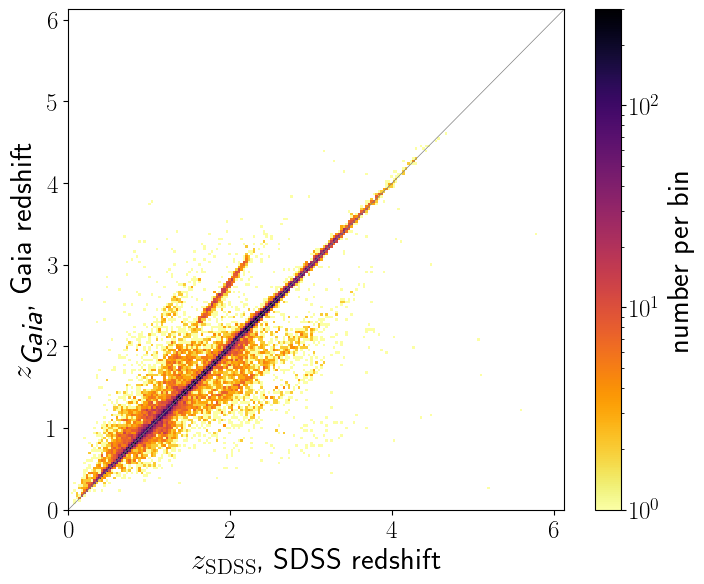

In [163]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_spz_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

### dz error cumulative histograms

In [164]:
dz_spzraw_test = (z_spzraw_test - z_sdss_test)/(1+z_sdss_test)
dz_spz_test = (z_spz_test - z_sdss_test)/(1+z_sdss_test)
dz_gaia_test = (z_gaia_test - z_sdss_test)/(1+z_sdss_test)

In [165]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

TODO: it looks worse when we do the softening vs just the z=0.1 hard cut. better way to choose the min than im doing maybe?

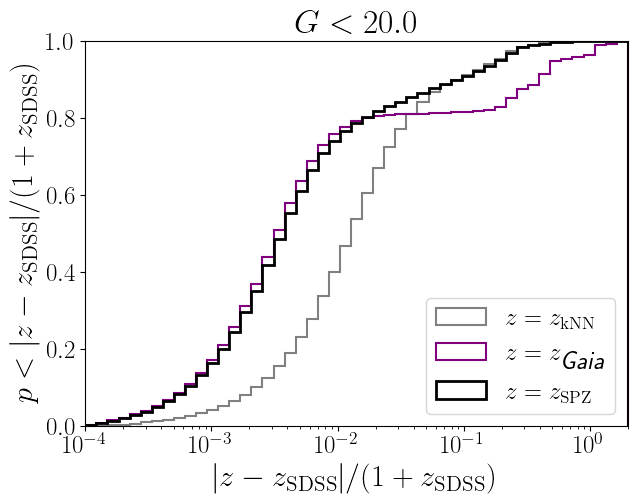

In [166]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_lo}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='purple', label=r'$z=z_\mathrm{\emph{Gaia}}$')
plt.hist(abs(dz_spz_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=r'$z=z_\mathrm{SPZ}$')
plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

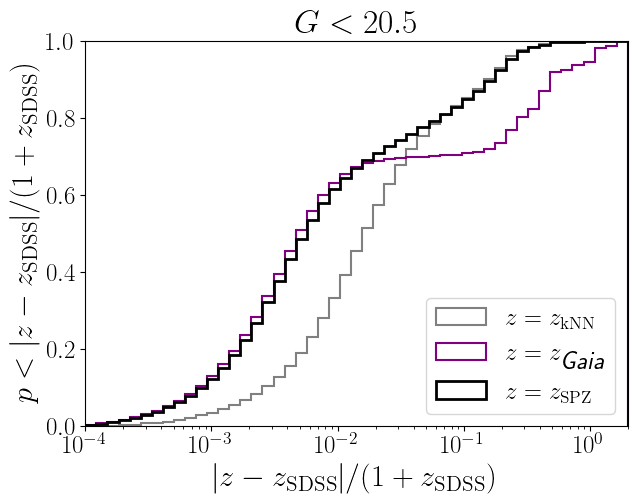

In [167]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_hi}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Ghi_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Ghi_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color=color_gaia, label=r'$z=z_\mathrm{\emph{Gaia}}$')
plt.hist(abs(dz_spz_test[idx_Ghi_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=r'$z=z_\mathrm{SPZ}$')
plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fraction of outliers as function of G

TODO why is this so different than earlier version??

[18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3
 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5]


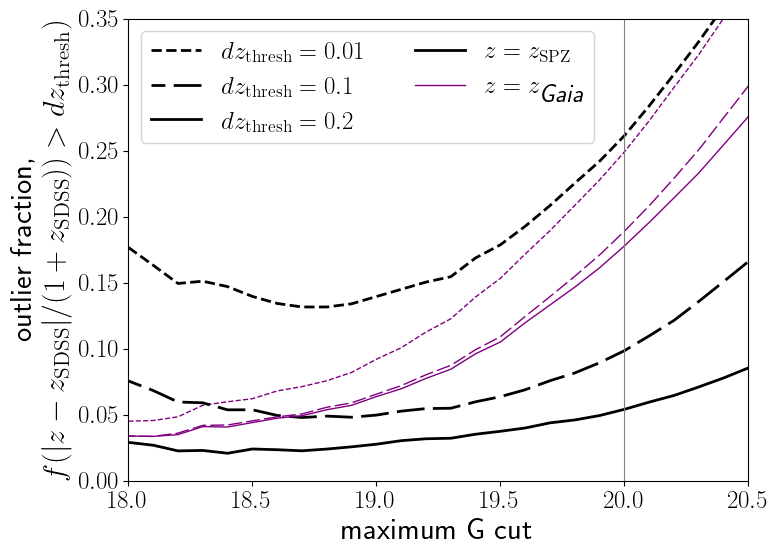

In [168]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz_labeled['phot_g_mean_mag'][i_test]
G_maxs = np.arange(18.0, 20.501, 0.1)
print(G_maxs)

dz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz_thresh in enumerate(dz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spz = np.empty(len(G_maxs))
    f_outliers_gaia = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spz[i] = np.sum(np.abs(dz_spz_test[i_insample]) > dz_thresh) / n_insample[i]
        f_outliers_gaia[i] = np.sum(np.abs(dz_gaia_test[i_insample]) > dz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spz, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz_thresh}$')
    plt.plot(G_maxs, f_outliers_gaia, color=color_gaia, alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + r'$f(|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS}))>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.35)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spz = Line2D([], [], color='k', lw=2)#, label='$z=z_\mathrm{SPZ/QSOC}$')
line_gaia = Line2D([], [], color=color_gaia, lw=1)#, label='$z=z_\mathrm{QSOC}$')
handles.extend([line_spz, line_gaia])
labels.extend(['$z=z_\mathrm{SPZ}$', '$z=z_\mathrm{\emph{Gaia}}$'])

plt.legend(handles, labels, ncol=2)

plt.axvline(20.0, color='grey', lw=0.8)

fn = f'{plot_dir}/redshift_outliers_vs_Gmax.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Selection function systematics maps

In [169]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

64 49152
Area per pixel: 0.839 deg


In [171]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Generating new dust map (../data/maps/map_dust_NSIDE64.npy)
NPIX for dust map sampling: 50331648
Saved dust map to ../data/maps/map_dust_NSIDE64.npy


In [173]:
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
map_stars = maps.get_star_map(NSIDE=NSIDE, fn_map=fn_starmap)
map_stardens = map_stars/area_per_pixel

Generating new star map (../data/maps/map_stars_NSIDE64.npy)
Saved star map to ../data/maps/map_stars_NSIDE64.npy


In [176]:
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
map_m10 = maps.get_m10_map(NSIDE=NSIDE, fn_map=fn_m10map)

M10 map already exists, loading from ../data/maps/map_m10_NSIDE64.npy


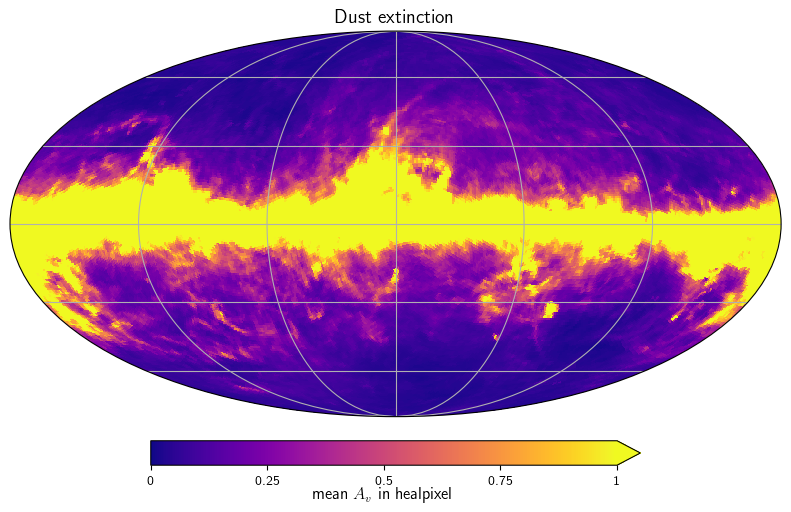

In [177]:
projview(map_dust, title=rf"Dust extinction",
         unit=r"mean $A_v$ in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=0.0, max=1.0, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         graticule=True)

fn = f'{plot_dir}/systematics_map_dust.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

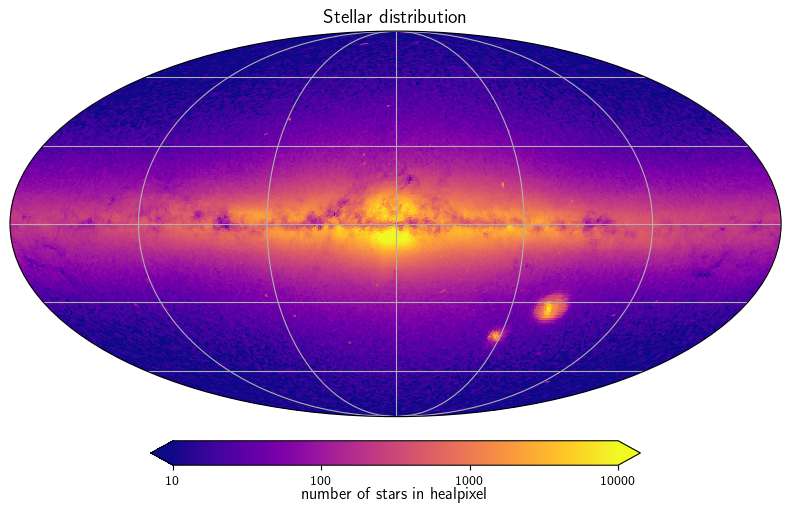

In [178]:
projview(map_stars, title=rf"Stellar distribution",
         unit=r"number of stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

fn = f'{plot_dir}/systematics_map_stars.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

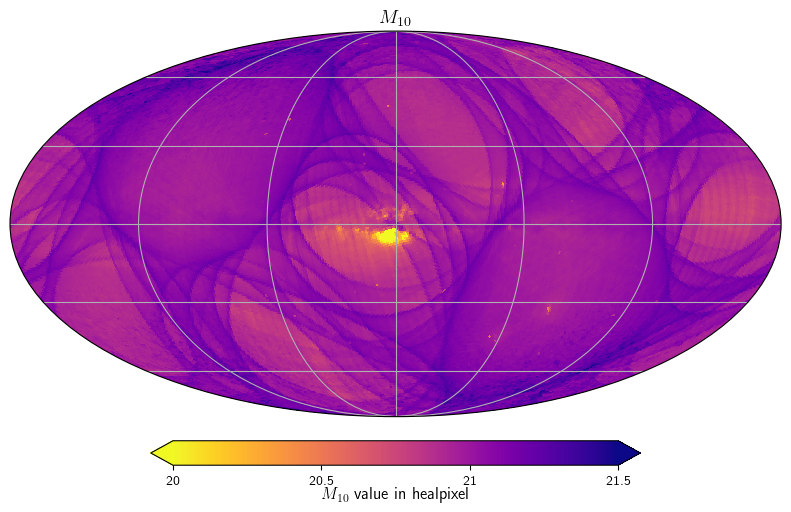

In [179]:
# reverse colormap bc high is worse here
projview(map_m10, title=r"$M_{10}$",
         unit=r"$M_{10}$ value in healpixel", cmap=cmap_map+'_r', coord=['C', 'G'],
         min=20.0, max=21.5, cbar_ticks=[20.0, 20.5, 21.0, 21.5],
         graticule=True)

fn = f'{plot_dir}/systematics_map_m10.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Catalog properties

### Sky distribution

In [194]:
map_gqlo = get_ndens_map(tab_gqlo['ra'], tab_gqlo['dec'])

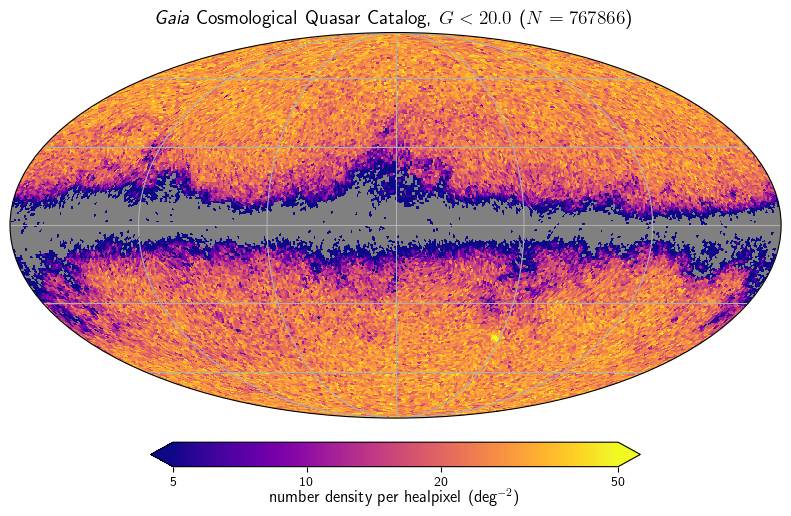

In [199]:
title_gqlo = rf"{name_catalog}, $G<{G_lo}$ ($N={len(tab_gqlo)}$)"
projview(map_gqlo, title=title_gqlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=50, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50])

fn = f'{plot_dir}/{abbrv_catalog}_G{G_lo}_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [200]:
map_gqhi = get_ndens_map(tab_gqhi['ra'], tab_gqhi['dec'])

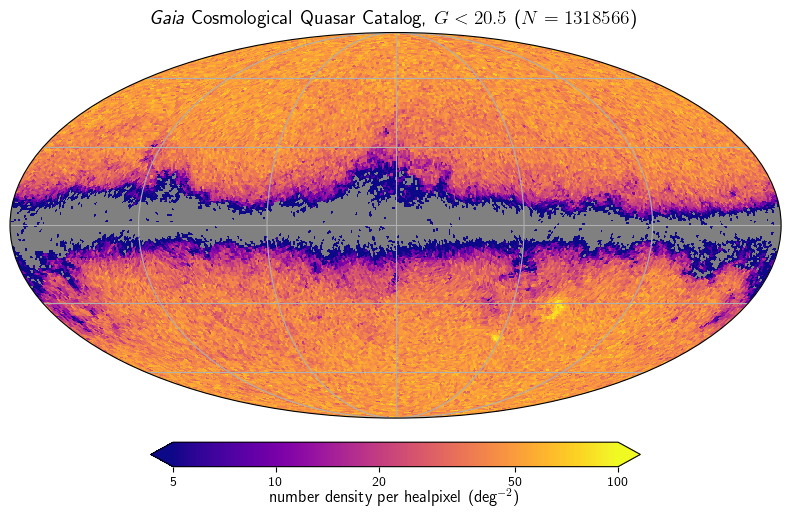

In [201]:
title_gqhi = rf"{name_catalog}, $G<{G_hi}$ ($N={len(tab_gqhi)}$)"
projview(map_gqhi, title=title_gqhi,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=100, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100])

fn = f'{plot_dir}/{abbrv_catalog}_G{G_hi}_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Redshift distribution

GaiaQ, $z_\mathrm{SPZ}$
1318566
1318566
1.467
GaiaQ, $z_\mathrm{\emph{Gaia}}$
1318566
1318566
1.604
\emph{Gaia} candidates, $z_\mathrm{QSOC}$
6649162
3979135


/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.644
\emph{Gaia} purer, $z_\mathrm{QSOC}$
1942825
1355077
1.606
SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$
245308
223417
1.698


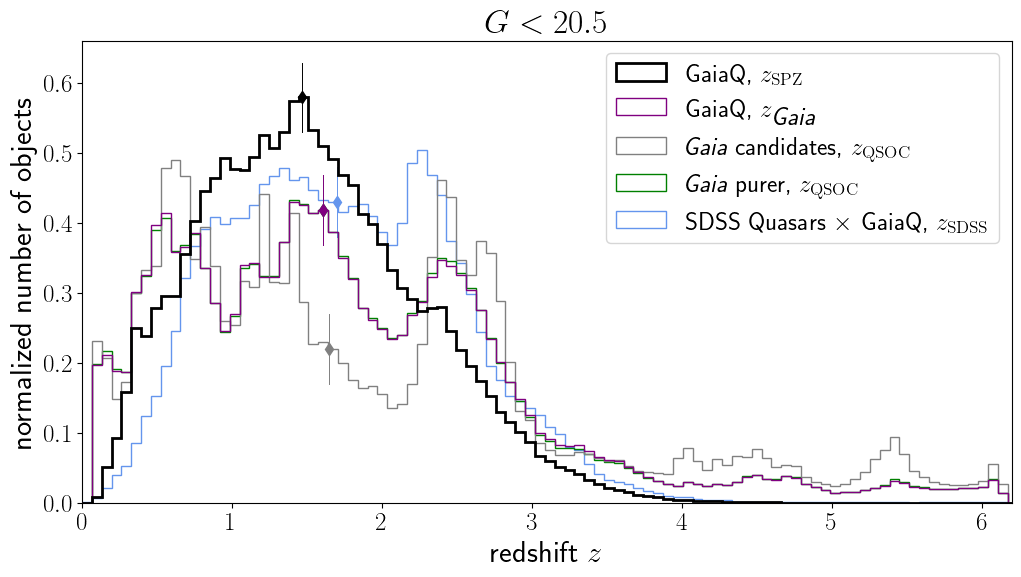

In [220]:
alpha = 1
lw = 1
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

tabs_znames = [(tab_gqhi, 'redshift_spz'),
              (tab_gqhi, 'redshift_qsoc'),
              (tab_gall, 'redshift_qsoc'),
              (tab_gpurer, 'redshift_qsoc'),
              (tab_spz_labeled, 'z_sdss')
             ]

# z_data = [tab_gqhi['redshift_spz'],
#           tab_gqhi['redshift_qsoc'],
#           tab_gall['redshift_qsoc'],
#           tab_gpurer['redshift_qsoc'],
#           tab_spz_labeled['z_sdss']
#          ]

labels = [r'GaiaQ, $z_\mathrm{SPZ}$',
          r'GaiaQ, $z_\mathrm{\emph{Gaia}}$',
          r'\emph{Gaia} candidates, $z_\mathrm{QSOC}$',
          r'\emph{Gaia} purer, $z_\mathrm{QSOC}$',
          r'SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$'
         ]

colors = ['black', color_gaia, 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(12,6))
plt.title(rf"$G < {G_hi}$")

lw_med = 0.7
for ii in range(len(tabs_znames)):
    print(labels[ii])
    tab, z_name = tabs_znames[ii]
    print(len(tab))
    i_G = tab['phot_g_mean_mag'] < G_hi

    z_data = tab[i_G][z_name]
    i_finite = np.isfinite(z_data)
    z_data = z_data[i_finite]
    print(len(z_data))

    ns, bs, _ = plt.hist(z_data, bins=z_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
    z_med = np.median(z_data)
    # figure out where to plot median
    bb = np.digitize(z_med, bs)
    nval = ns[bb-1]
    plt.plot([z_med]*2, [nval-0.05, nval+0.05], lw=lw_med, color=colors[ii], zorder=zorders[ii])
    plt.plot(z_med, nval, marker='d', color=colors[ii], zorder=zorders[ii])
    print(f'{z_med:.3f}')

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

plt.xlim(0,6.2)

fn = f'{plot_dir}/redshift_dists.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: does it makes sense that gaia purer and gaiaq qsoc redshifts are essentially the same?